This file include the macro data acquisition and financial turbulence calculation process.

All output data are placed in the `./data/raw` fold.

The acquisition process of six factor data is in other file.

### Import Lib

In [2]:
# data api
import yfinance as yf
from fredapi import Fred

# data processor
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from dotenv import load_dotenv
import os

ROOT = Path.cwd()  # or your project root
from utilities import *

# Load environment variables from .env
load_dotenv()

# Access variables
fred_key = os.getenv("FRED_API_KEY")
fred = Fred(api_key=fred_key) # fred is an object - an instance of the `Fred` Class # can apply your own api_key on the website, quite easy

### 1 - Financial Turbulence

The identification of financial turbulence allows for a deeper understanding of market dynamics and the potential risks associated with market-wide disruptions.  

They measure financial turbulence as:

$$
d_t = (y_t - \mu)' \Sigma^{-1} (y_t - \mu) 
$$

where:

- $d_t$ = turbulence for a particular time period $t$  
- $y_t$ = vector of asset returns for period $t$  
- $\mu$ = sample average vector of historical returns  
- $\Sigma$ = sample covariance matrix of historical returns

|  Ticker  | Sector Name (English)                     | Notes                                       |
| :------: | :---------------------------------------- | :------------------------------------------ |
|  **XLK** | Technology Select Sector SPDR             | Tracks S&P 500 Information Technology Index |
|  **XLF** | Financial Select Sector SPDR              | S&P 500 Financials Index                    |
|  **XLE** | Energy Select Sector SPDR                 | Oil & gas producers, energy equipment       |
|  **XLI** | Industrial Select Sector SPDR             | Transportation, manufacturing, aerospace    |
|  **XLP** | Consumer Staples Select Sector SPDR       | Food, beverages, household goods            |
|  **XLY** | Consumer Discretionary Select Sector SPDR | Retail, automotive, luxury, entertainment   |
|  **XLU** | Utilities Select Sector SPDR              | Electric and gas utilities companies        |
|  **XLB** | Materials Select Sector SPDR              | Chemicals, metals, construction materials   |
|  **XLC** | Communication Services Select Sector SPDR | Telecom & media (e.g. Meta, Alphabet)       |
| **XLRE** | Real Estate Select Sector SPDR            | Real estate investment trusts (REITs)       |

- These are sector ETFs - exchange-traded funds that track the S&P500 sector indices.

---
Some comments of this concept:<br>
- The indicator **Financial turbulence** is actually a kind of **Mahalanobis distance**.<br>
- Mahalanobis distance measures how many standard deviations a point is from the mean, considering correlations between variables. You can think of it as an oval.
- It’s essentially the Euclidean distance in a whitened (decorrelated and standardized) space, obtained by using the inverse covariance matrix to rotate and scale the data, making the comparison more objective.


Prerequisites of calculating **Mahalanobis distance**:

| Concept                        | Requirement                                                    | Why it matters                                                               |
| ------------------------------ | -------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| **Covariance invertibility**   | ($\Sigma$) must be **positive definite** (invertible)            | Otherwise ($\Sigma^{-1}$) doesn’t exist                                        |
| **Sufficient historical data** | Number of observations (N > p) (assets)                        | Needed to estimate a stable covariance matrix                                |
| **Stationarity (approx.)**     | The distribution of returns shouldn’t drift too fast over time | So that μ and Σ estimated from history are meaningful for the current period |
| **No exact multicollinearity** | Assets must not be perfectly correlated                        | Otherwise covariance matrix is singular                                      |


In [3]:
tickers = ["XLK","XLF","XLE","XLI","XLP","XLY","XLU","XLB"]  # exclude "XLC", "XLRE" 
sp_sectors_data = yf.download(tickers, start="1999-11-30", end="2025-8-31", interval="1mo")["Close"]
sp_sectors_returns = sp_sectors_data.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed


In [4]:
# sp_sectors_data
sp_sectors_returns

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLY
Date,,,,,,,,
2000-01-01,-0.118590,0.011047,-0.026024,-0.078157,-0.061466,0.011767,-0.011503,-0.123149
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.055715
2000-03-01,0.098288,0.120669,0.178300,0.136861,0.083893,0.034272,0.101029,0.139294
2000-04-01,-0.030926,-0.011625,0.013364,0.016539,-0.091848,0.056399,0.073402,-0.018912
2000-05-01,-0.031557,0.117424,0.022322,-0.004219,-0.103977,0.071329,-0.002194,-0.053981
...,...,...,...,...,...,...,...,...
2025-04-01,-0.019657,-0.131858,-0.017524,0.004220,0.018688,0.007267,0.007736,0.001737
2025-05-01,0.029205,0.012795,0.045119,0.088401,0.099729,0.012220,0.038276,0.083849
2025-06-01,0.017026,0.040231,0.027669,0.032909,0.096661,-0.022456,-0.003174,0.016511


In [5]:
# Download the Treasury yields (daily frequenciy)
tickers = { # Define a dict mapping FRED series IDs to readable labels 
    "GS1" : "1Y", # 1 year constant maturity
    "GS2" : "2Y",
    "GS10" : "10Y"
}

treasury_yields = pd.DataFrame({label: fred.get_series(ticker) for ticker, label in tickers.items()})["2000-01-01":"2025-08-31"] # the data frequency is already monthly
    # In FRED's terminology, a series is one time sries of economic data

In [6]:
treasury_yields

,1Y,2Y,10Y
2000-01-01,6.12,6.44,6.66
2000-02-01,6.22,6.61,6.52
2000-03-01,6.22,6.53,6.26
2000-04-01,6.15,6.40,5.99
2000-05-01,6.33,6.81,6.44
...,...,...,...
2025-04-01,3.95,3.78,4.28
2025-05-01,4.09,3.92,4.42
2025-06-01,4.06,3.89,4.38
2025-07-01,4.08,3.88,4.39


In [7]:
combined_treasury_rate_sp_sectors_returns = pd.concat([sp_sectors_returns*100, treasury_yields], axis=1)

In [8]:
combined_treasury_rate_sp_sectors_returns 

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLY,1Y,2Y,10Y
2000-01-01,-11.858980,1.104737,-2.602386,-7.815691,-6.146616,1.176679,-1.150317,-12.314878,6.12,6.44,6.66
2000-02-01,-10.046924,-4.233389,-10.704598,-5.517238,10.506766,-11.701394,-12.153778,-5.571456,6.22,6.61,6.52
2000-03-01,9.828770,12.066890,17.830005,13.686120,8.389310,3.427230,10.102939,13.929439,6.22,6.53,6.26
2000-04-01,-3.092636,-1.162455,1.336355,1.653905,-9.184756,5.639928,7.340167,-1.891232,6.15,6.40,5.99
2000-05-01,-3.155671,11.742412,2.232188,-0.421913,-10.397719,7.132888,-0.219442,-5.398066,6.33,6.81,6.44
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-1.965704,-13.185826,-1.752443,0.421952,1.868776,0.726664,0.773622,0.173681,3.95,3.78,4.28
2025-05-01,2.920484,1.279496,4.511893,8.840123,9.972863,1.222038,3.827634,8.384872,4.09,3.92,4.42
2025-06-01,1.702572,4.023061,2.766876,3.290855,9.666091,-2.245557,-0.317379,1.651077,4.06,3.89,4.38
2025-07-01,0.417846,3.666359,0.342707,3.357267,3.927448,-0.793781,5.639001,2.103160,4.08,3.88,4.39


In [9]:

exploratory_data_analysis_pd_dataframe(combined_treasury_rate_sp_sectors_returns)

The shape:
(308, 11)

The number of na data:
XLB    0
XLE    0
XLF    0
XLI    0
XLK    0
XLP    0
XLU    0
XLY    0
1Y     0
2Y     0
10Y    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     308 non-null    float64
 1   XLE     308 non-null    float64
 2   XLF     308 non-null    float64
 3   XLI     308 non-null    float64
 4   XLK     308 non-null    float64
 5   XLP     308 non-null    float64
 6   XLU     308 non-null    float64
 7   XLY     308 non-null    float64
 8   1Y      308 non-null    float64
 9   2Y      308 non-null    float64
 10  10Y     308 non-null    float64
dtypes: float64(11)
memory usage: 28.9 KB
None

The numberic profile of the input data:
              XLB         XLE         XLF         XLI         XLK         XLP  \
count  308.000000  308.000000  308.

In [10]:
def compute_financial_turbulence(returns_df: pd.DataFrame) -> pd.Series:
    """
    Compute the Financial Turbulence Index following Kritzman & Li (2010).

    Parameters
    ----------
    returns_df : pd.DataFrame
        DataFrame of asset returns (each column is one asset, e.g., sectors or Treasuries).
        Data should be stationary and aligned by date.

    Returns
    -------
    pd.Series
        Financial Turbulence values indexed by date.
    """
    data = returns_df.copy()
    mu = data.mean().values
    cov = data.cov().values

    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is singular or ill-conditioned.")
    
    diff = data.values - mu
    turbulence_array = np.einsum('ij, jk, ik ->i', diff, inv_cov, diff)
    turbulence = pd.Series(turbulence_array, index = data.index, name = "financial_turbulence")

    return turbulence

In [11]:
financial_turbulence = compute_financial_turbulence(combined_treasury_rate_sp_sectors_returns)
financial_turbulence.name = 'financial_turbulence'

In [12]:
exploratory_data_analysis_pd_dataframe(financial_turbulence)


The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Series name: financial_turbulence
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
count    308.000000
mean      10.964286
std        7.751152
min        2.124781
25%        5.731498
50%        8.371961
75%       13.452722
max       44.591032
Name: financial_turbulence, dtype: float64

The skewness of the input dataframe:
1.7207626565014174

The kurtosis of the input dataframe:
3.148220394568089


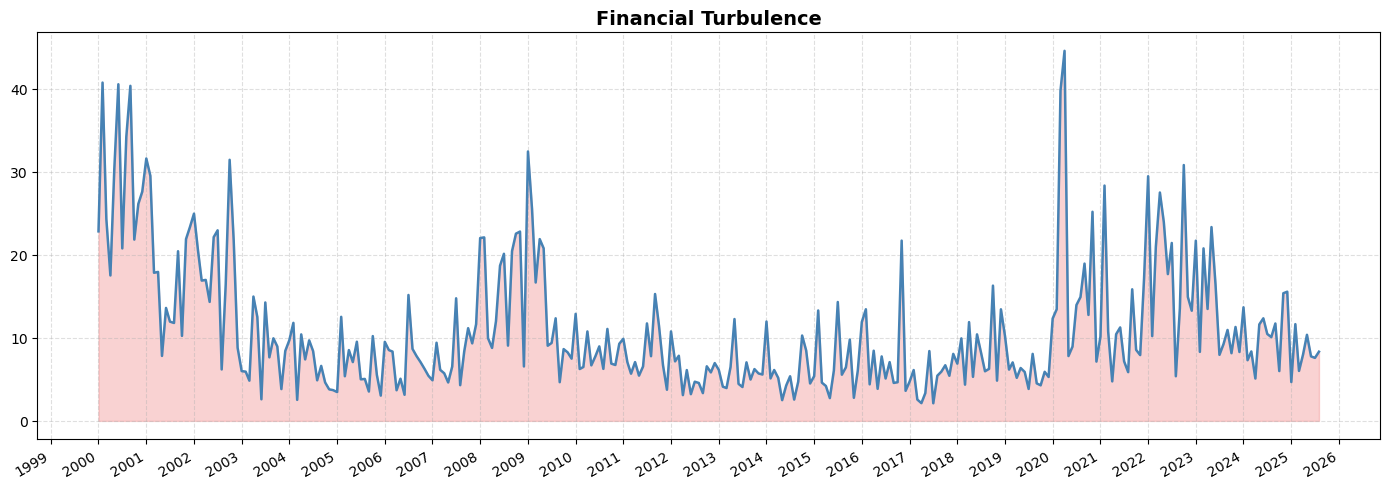

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

s = financial_turbulence.squeeze()  

plt.figure(figsize=(14, 5))
plt.plot(s.index, s.values, color='steelblue', linewidth=1.8, label='')

plt.fill_between(s.index, s.values, 0, where=(s.values > 0), color='lightcoral', alpha=0.35)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))     
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  

plt.title('Financial Turbulence', fontsize=14, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.xlabel('', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### 2 - Financial Condition

Variables:
- Financial Condition – Risk
- Financial Condition – Credit
- Financial Condition – Leverage
Source: “FRED, National Financial Conditions Index”

These come from the Chicago Fed’s National Financial Conditions Index (NFCI), which actually has subindexes: Risk, Credit, and Leverage.

In [13]:
tickers = {
    "NFCIRISK": "nfc_risk",
    "NFCICREDIT": "nfc_credit",
    "NFCILEVERAGE": "nfc_leverage"
}

nfc = pd.DataFrame({name: fred.get_series(ticker) for ticker, name in tickers.items()})

In [14]:
nfc

,nfc_risk,nfc_credit,nfc_leverage
1971-01-08,0.61212,-1.12905,-1.03535
1971-01-15,0.64162,-1.13101,-1.05320
1971-01-22,0.67665,-1.13421,-1.06969
1971-01-29,0.71577,-1.13910,-1.08418
1971-02-05,0.75783,-1.14617,-1.09618
...,...,...,...
2025-10-03,-0.58416,-0.04464,-0.19125
2025-10-10,-0.58401,-0.04310,-0.15219
2025-10-17,-0.58254,-0.04147,-0.11647
2025-10-24,-0.58121,-0.03994,-0.08567


In [15]:
def data_process_helper(data:pd.DataFrame) -> pd.DataFrame:
    data_monthly = data.resample('M').mean()
    data_sliced = data_monthly.loc['2000-01-01':'2025-09-01']
    data_sliced.index = data_sliced.index.to_period('M').to_timestamp('M')  # currently end-of-month
    data_sliced.index = data_sliced.index.to_period('M').to_timestamp('S')  # ← start-of-month
    return data_sliced

In [16]:
type(financial_turbulence)

pandas.core.series.Series

In [17]:
financial_condition = data_process_helper(nfc)
exploratory_data_analysis_pd_dataframe(financial_condition)

The shape:
(308, 3)

The number of na data:
nfc_risk        0
nfc_credit      0
nfc_leverage    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nfc_risk      308 non-null    float64
 1   nfc_credit    308 non-null    float64
 2   nfc_leverage  308 non-null    float64
dtypes: float64(3)
memory usage: 9.6 KB
None

The numberic profile of the input data:
         nfc_risk  nfc_credit  nfc_leverage
count  308.000000  308.000000    308.000000
mean    -0.377825    0.066171     -0.021269
std      0.504857    0.426708      0.921814
min     -0.798570   -0.436042     -1.970656
25%     -0.651411   -0.127908     -0.453421
50%     -0.522617   -0.021577     -0.173749
75%     -0.312148    0.150266      0.145729
max      2.856655    2.682325      3.902172

The skewness of the input

In [18]:
financial_condition

,nfc_risk,nfc_credit,nfc_leverage
2000-01-01,-0.258570,0.058478,1.317603
2000-02-01,-0.246968,0.025660,1.351058
2000-03-01,-0.155668,0.063858,1.181748
2000-04-01,-0.033340,0.119385,0.876302
2000-05-01,0.061378,0.159085,0.602598
...,...,...,...
2025-04-01,-0.403042,0.017880,-0.419015
2025-05-01,-0.446606,-0.008484,-0.455824
2025-06-01,-0.503590,-0.036160,-0.520180
2025-07-01,-0.538555,-0.048125,-0.525730


#### 2.1 Interpretation of these 3 feature

| Subindex                             | What It Measures                                                   | Interpretation of High Values (>0)                                    | Interpretation of Low Values (<0)                             | Notes                                                    |
| ------------------------------------ | ------------------------------------------------------------------ | --------------------------------------------------------------------- | ------------------------------------------------------------- | -------------------------------------------------------- |
| **Risk Subindex (NFCRISK)**          | Market risk appetite, volatility, credit spreads, funding stress   | Higher market stress, rising volatility, tighter risk conditions      | Lower stress, calm markets, easier risk-taking                | Standardized Z-score (mean 0, std 1)                     |
| **Credit Subindex (NFCICREDIT)**     | Lending conditions for households and firms; bank credit standards | Tighter credit supply, stricter lending, rising borrowing constraints | Easier lending conditions, credit flowing freely              | Negative values = accommodative credit environment       |
| **Leverage Subindex (NFCILEVERAGE)** | Balance-sheet leverage of financial intermediaries; leverage cycle | Deleveraging, balance-sheet contraction, tighter financial conditions | Leveraging-up, expansion of balance sheets, looser conditions | Captures broker-dealer leverage and funding availability |
| **Common Scale**                     | All three are standardized factors                                 | Values > +1 = unusually tight                                         | Values < –1 = unusually easy                                  | Derived from 100+ market/credit variables                |


The three NFCI subindexes — Risk, Credit, and Leverage — are not produced using simple linear regression.


They are generated using a Dynamic Factor Model (DFM), estimated through Kalman filtering. (`too much stuff to learn, skip it temporarily`)

### 3 - Equity Valuation

Variable:
- Cyclically Adjusted PE Ratio (CAPE Ratio)
- Source: “Online Data Robert Shiller” (http://www.econ.yale.edu/~shiller/data.htm)
Robert Shiller (Yale) publishes this for free (CAPE, earnings yield = 1/CAPE). We can download the Excel/CSV manually from his website and then load with pandas. 

`Caveat:`
- This data source only contain the **CAPE Ratio for stocks in S&P500**, but our factor data is based on the **Ken French Data Library**, which covers all NYSE, AMEX, and NASDAQ stocks (broader). Might need further modification.

In [19]:
ROOT = Path.cwd() # current working directory
PROC = ROOT / os.getenv("DATA_DIR_PROCESSED")
shiller_data = pd.read_excel(PROC/"ie_data.xls", sheet_name='Data', skiprows=7)

print(shiller_data.head())

      Date     P     D    E        CPI     Fraction Rate GS10       Price  \
0  1871.01  4.44  0.26  0.4  12.464061  1871.041667      5.32  115.656018   
1  1871.02   4.5  0.26  0.4  12.844641  1871.125000  5.323333  113.745800   
2  1871.03  4.61  0.26  0.4  13.034972  1871.208333  5.326667  114.824791   
3  1871.04  4.74  0.26  0.4  12.559226  1871.291667      5.33  122.535037   
4  1871.05  4.86  0.26  0.4  12.273812  1871.375000  5.333333  128.558754   

   Dividend     Price.1  ...  CAPE  Unnamed: 13  TR CAPE  Unnamed: 15  Yield  \
0  6.772650  115.656018  ...   NaN          NaN      NaN          NaN    NaN   
1  6.571980  114.293465  ...   NaN          NaN      NaN          NaN    NaN   
2  6.476019  115.919917  ...   NaN          NaN      NaN          NaN    NaN   
3  6.721331  124.269152  ...   NaN          NaN      NaN          NaN    NaN   
4  6.877629  130.959363  ...   NaN          NaN      NaN          NaN    NaN   

    Returns  Returns.1  Real Return  Real Return.1  Retu

Diff between the CAPE and TR CAPE

| Column name   | Meaning        | Key difference      |
| ------------------------- | ------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **CAPE (or P/E10)**       | *Cyclically Adjusted Price–Earnings Ratio*       | Uses **S&P 500 price index** only (no dividends). Measures how expensive the market’s **price level** is relative to 10-year average earnings.                                                      |
| **TR CAPE (or TR P/E10)** | *Cyclically Adjusted **Total Return** P/E Ratio* | Uses **total-return index** instead of price index. That means it assumes **dividends are reinvested**, so prices grow faster. It adjusts the “P” part to reflect cumulative dividend reinvestment. |


$$
\text{CAPE} = \frac{\text{Price Index}}{\text{10-Year Average Real Earnings}}
$$

$$
\text{TR CAPE} = \frac{\text{Total Return Index (Price + Reinvested Dividends)}}{\text{10-Year Average Real Earnings}}
$$



In [20]:
cape = shiller_data[['Date', 'TR CAPE']].dropna() # here we use the TR CAPE (Cyclically Adjusted PE Ratio)

# convert the data type and set it as the index 
date_num = cape["Date"].astype(float)
year = date_num.astype(int)
month = ((date_num - year) * 100).round().astype(int).clip(1, 12)
dt = pd.to_datetime(dict(year=year, month=month, day=1))
cape = cape.drop(columns=["Date"]).assign(Date=dt).set_index("Date").sort_index()

# set the time range
cape = cape.loc['2000-01-01': '2025-08-01']
equity_valuation = cape.copy()

In [21]:
exploratory_data_analysis_pd_dataframe(cape) # the result show that do not need interplation

The shape:
(308, 1)

The number of na data:
TR CAPE    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TR CAPE  308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
          TR CAPE
count  308.000000
mean    30.020385
std      6.154087
min     14.592704
25%     25.914007
50%     29.137699
75%     33.478754
max     47.587687

The skewness of the input dataframe:
TR CAPE    0.454212
dtype: float64

The kurtosis of the input dataframe:
TR CAPE    0.337856
dtype: float64


#### 3.1 More Background Info of this feature

- link: https://shillerdata.com

- US Stock market data used in my book, Irrational Exuberance [Princeton University Press[BS1]  2000, Broadway Books 2001, 2nd  ed., 2005, 3rd ed. 2015] as updated are available for download below. This data set consists of monthly stock price, dividends, and earnings data and interest rates and the consumer price index (to allow conversion to real values), starting January 1871. The price, dividend, and earnings series are from the same sources as described in Chapter 26 of my book (Market Volatility [Cambridge, MA: MIT Press, 1989]), although now I provide monthly data, rather than annual data. Monthly dividend and earnings data are computed from the S&P four-quarter totals for the quarters since 1926, with linear interpolation to monthly figures. Dividend and earnings data before 1926 are from Cowles and Associates (Common Stock Indexes, 2nd ed. [Bloomington, Ind.: Principia Press, 1939]), interpolated from annual data. Stock price data are monthly averages of daily closing prices. The CPI-U (Consumer Price Index-All Urban Consumers) published by the U.S. Bureau of Labor Statistics begins in 1913; for years before 1913 I spliced to the CPI Warren and Pearson's price index, by multiplying it by the ratio of the indexes in January 1913. See George F. Warren and Frank A. Pearson, Gold and Prices (New York: John Wiley and Sons, 1935). Data are from their Table 1, pp. 11–14.

- As of September 2018, I now also include an alternative total return version of the data that is somewhat different. As documented in Bunn & Shiller (2014) and Jivraj and Shiller (2017), changes in corporate payout policy (i. e. share repurchases rather than dividends) have now become a dominant approach in the United States for cash distribution to shareholders). This may affect the level of the CAPE ratio through changing the growth rate of earnings per share. This subsequently may affect the average of the real earnings per share used in the CAPE ratio. A total return CAPE corrects for this bias through reinvesting dividends into the price index and appropriately scaling of earnings per share.


#### 3.1 More Background Info of this feature

- link: https://shillerdata.com

- US Stock market data used in my book, Irrational Exuberance [Princeton University Press[BS1]  2000, Broadway Books 2001, 2nd  ed., 2005, 3rd ed. 2015] as updated are available for download below. This data set consists of monthly stock price, dividends, and earnings data and interest rates and the consumer price index (to allow conversion to real values), starting January 1871. The price, dividend, and earnings series are from the same sources as described in Chapter 26 of my book (Market Volatility [Cambridge, MA: MIT Press, 1989]), although now I provide monthly data, rather than annual data. Monthly dividend and earnings data are computed from the S&P four-quarter totals for the quarters since 1926, with linear interpolation to monthly figures. Dividend and earnings data before 1926 are from Cowles and Associates (Common Stock Indexes, 2nd ed. [Bloomington, Ind.: Principia Press, 1939]), interpolated from annual data. Stock price data are monthly averages of daily closing prices. The CPI-U (Consumer Price Index-All Urban Consumers) published by the U.S. Bureau of Labor Statistics begins in 1913; for years before 1913 I spliced to the CPI Warren and Pearson's price index, by multiplying it by the ratio of the indexes in January 1913. See George F. Warren and Frank A. Pearson, Gold and Prices (New York: John Wiley and Sons, 1935). Data are from their Table 1, pp. 11–14.

- As of September 2018, I now also include an alternative total return version of the data that is somewhat different. As documented in Bunn & Shiller (2014) and Jivraj and Shiller (2017), changes in corporate payout policy (i. e. share repurchases rather than dividends) have now become a dominant approach in the United States for cash distribution to shareholders). This may affect the level of the CAPE ratio through changing the growth rate of earnings per share. This subsequently may affect the average of the real earnings per share used in the CAPE ratio. A total return CAPE corrects for this bias through reinvesting dividends into the price index and appropriately scaling of earnings per share.


### 4 - Monetary Policy Expectation

Varibales:
- Effective Federal Funds Rate
- Monetary Policy Expectations


Monetary Policy Expectations is vague. In practice, people proxy it with:
- Fed Funds futures implied rate,
- OIS curve near-term expectations,
- or Survey-based expectations.

Those are usually not free (they’re from CME futures, Bloomberg, Refinitiv). The paper is almost certainly using some proprietary forward-rate expectation measure. Since we cannot access policy expectations so far. We add a similar feature: 
- 3M-FFR spread (3 month treasury yield - effective fed funds rate) which reflects the near-term policy.





In [22]:
effr = fred.get_series('FEDFUNDS').loc['2000-01-01': '2025-08-01']   # Retrieve Effective Federal Funds Rate (FEDFUNDS)
effr.name = 'effr'
t3m = fred.get_series('DGS3MO')      # 3-month Treasury yield
t3m_m = t3m.resample('M').mean()
t3m_m.index = t3m_m.index.to_period('M').to_timestamp('S')
t3m_m = t3m_m.loc['2000-01-01': '2025-08-01']

expectation_proxy = t3m_m - effr        # 3M-FFR spread
expectation_proxy.name = 't3m effr spread'

monetary_policy_expectation = pd.concat([effr, expectation_proxy], axis = 1)


In [23]:
effr

2000-01-01    5.45
2000-02-01    5.73
2000-03-01    5.85
2000-04-01    6.02
2000-05-01    6.27
              ... 
2025-04-01    4.33
2025-05-01    4.33
2025-06-01    4.33
2025-07-01    4.33
2025-08-01    4.33
Name: effr, Length: 308, dtype: float64

In [24]:
exploratory_data_analysis_pd_dataframe(expectation_proxy)
exploratory_data_analysis_pd_dataframe(effr)

The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Series name: t3m effr spread
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
count    308.000000
mean      -0.064596
std        0.246398
min       -1.326500
25%       -0.099625
50%       -0.044665
75%        0.022174
max        0.792500
Name: t3m effr spread, dtype: float64

The skewness of the input dataframe:
-1.6779871419551902

The kurtosis of the input dataframe:
7.227066600475236
The shape:
(308,)

The number of na data:
0

The Info of the input dataframe:
<class 'pandas.core.series.Series'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Series name: effr
Non-Null Count  Dtype  
--------------  -----  
308 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

The numberic profile o

#### 4.1 Interpretation of these features 

Effective Federal Funds Rate (EFFR)

FRED series code: FEDFUNDS

It represents:

The weighted-average interest rate at which depository institutions lend reserve balances to each other overnight.

This is the key short-term interest rate in the U.S. financial system.

### 5 - Inflation

In [25]:
# Core CPI (CPI excluding food and energy)
core_cpi = fred.get_series('CPILFESL')  # Core CPI (Index, 1982-84=100) 

# 1-year annualized change
core_cpi_1y = core_cpi.pct_change(periods=12).dropna()

# 10-year annualized change (120 months)
core_cpi_10y = ((core_cpi / core_cpi.shift(120)) ** (1/10) - 1).dropna()

In [26]:
cpi_1y = core_cpi_1y.loc['2000-01-01':'2025-08-01']
cpi_10y = core_cpi_10y.loc['2000-01-01':'2025-08-01']

cpi_1y.name = 'cpi_1y'
cpi_10y.name = 'cpi_10y'

### 6 - GDP

In [27]:
real_gdp = fred.get_series('GDPC1')  # Real GDP (chained dollars)
real_gdp_growth_qoq = real_gdp.pct_change().dropna()  # quarter-over-quarter # might need to convert quarterly -> monthly by foreard filling the same value 
real_gdp_growth_yoy = real_gdp.pct_change(4).dropna() # year-over-year

In [28]:
real_gdp_change = real_gdp.diff()
real_gdp_monthly = real_gdp_change.resample('M').ffill()
real_gdp_monthly.index = real_gdp_monthly.index.to_period('M').to_timestamp('S')
real_gdp_growth = real_gdp_monthly.loc['2000-01-01':'2025-08-01']
real_gdp_growth.name = 'real_gdp_growth_monthly'
print(real_gdp_growth.head(12))

2000-01-01     50.167
2000-02-01     50.167
2000-03-01     50.167
2000-04-01    252.761
2000-05-01    252.761
2000-06-01    252.761
2000-07-01     14.404
2000-08-01     14.404
2000-09-01     14.404
2000-10-01     84.453
2000-11-01     84.453
2000-12-01     84.453
Freq: MS, Name: real_gdp_growth_monthly, dtype: float64


### 7 - Target Index Market Regimes (K-Clustering)

S&P 500 data and three months' rolling drawdown calculation.

In [29]:
sp = yf.download("^GSPC", start="1999-01-01", end="2025-09-01", interval="1d") # ^GSPC is the ticker symbol for the S&P 500 Index on Yahoo Finance.
    # move the start date one year before to adapt the rolling window
sp_close = sp['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


The formula for calculating RollingDrawdown based on S&P 500 data:

$$RollingDrawdown(t) = \dfrac{P_t - \max_{t-63 \le s \le t} P_s}{\max_{t-63 \le s \le t} P_s}$$

In [30]:
sp

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1999-01-04,1228.099976,1248.810059,1219.099976,1229.229980,877000000
1999-01-05,1244.780029,1246.109985,1228.099976,1228.099976,775000000
1999-01-06,1272.339966,1272.500000,1244.780029,1244.780029,986900000
1999-01-07,1269.729980,1272.339966,1257.680054,1272.339966,863000000
1999-01-08,1275.089966,1278.239990,1261.819946,1269.729980,937800000
...,...,...,...,...,...
2025-08-25,6439.319824,6466.890137,6438.060059,6457.669922,4059070000
2025-08-26,6465.939941,6468.370117,6429.209961,6435.490234,4867680000


In [31]:
# Compute rolling 3-month (≈63 trading days) peak 
window = 63  # ~3 months of trading days
rolling_peak = sp_close.rolling(window=window, min_periods=1).max()
rolling_dd = (sp_close - rolling_peak) / rolling_peak   # this will be 0 at local peaks, negative otherwise
rolling_dd_=rolling_dd.dropna()

monthly_rolling_dd = rolling_dd.resample('M').min() # Downsample to monthly to make a cleaner plot like Exhibit 2 in page 5
    # We take the MIN within each month because drawdown is about worst pain
monthly_rolling_dd.index = monthly_rolling_dd.index.to_period('M').to_timestamp('S')
    # to_peroid means xxxx-xx
    # to_timestamp means xxxx-xx-xx
monthly_rolling_dd = monthly_rolling_dd.loc['2000-01-01':'2025-08-01']

In [32]:
type(monthly_rolling_dd)

pandas.core.frame.DataFrame

In [33]:
sp_3m_drawdown= monthly_rolling_dd.rename(columns = {'^GSPC' : 'sp_3m_drawdown'})

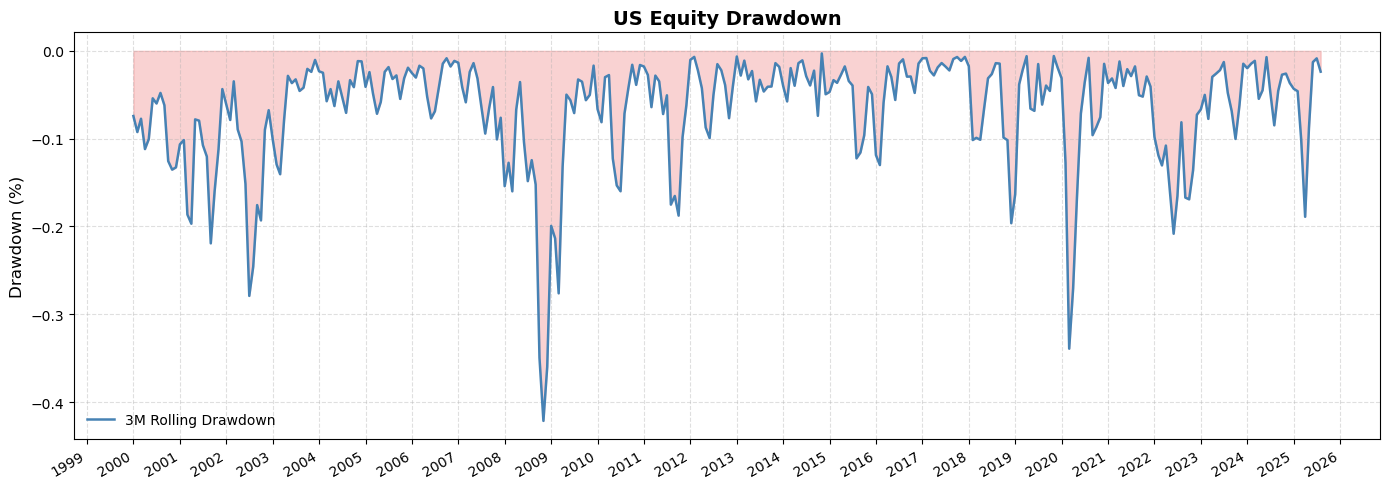

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

s = sp_3m_drawdown.squeeze()  

plt.figure(figsize=(14, 5))
plt.plot(s.index, s.values, color='steelblue', linewidth=1.8, label='3M Rolling Drawdown')

plt.fill_between(s.index, s.values, 0, where=(s.values < 0), color='lightcoral', alpha=0.35)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))     
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  

plt.title('US Equity Drawdown', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown (%)', fontsize=12)
plt.xlabel('', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [36]:
sp_3m_drawdown = monthly_rolling_dd.copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Prepare X (2D array) and keep dates for merging back
col = sp_3m_drawdown.columns[0]
X = sp_3m_drawdown[[col]].astype(float).values  # shape (T, 1)

# 2) Scale (important for distance-based methods, even in 1D)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# 3) (Optional) Elbow method to check K
def wcss_for_k(max_k=8):
    wcss = []
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(Xz)
        wcss.append(km.inertia_)
    return wcss

# 4) Fit K=3 as in the paper
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_raw = kmeans.fit_predict(Xz)  # 0/1/2 (arbitrary order)

# 5) Order labels by severity (mean drawdown) → 0=Normal, 1=Correction, 2=Bear
tmp = pd.DataFrame({
    'dd': sp_3m_drawdown[col].values,
    'label_raw': labels_raw
})
order = (
    tmp.groupby('label_raw')['dd']
       .mean()
       .sort_values(ascending=False)  # larger (less negative) = more "normal"
       .index.tolist()
)
# map raw → ordered labels 0,1,2
mapping = {raw:new for new,raw in enumerate(order)}
labels_ordered = np.array([mapping[r] for r in labels_raw])

# 6) Assemble result
regimes = sp_3m_drawdown.copy()
regimes['regime'] = labels_ordered  # 0=Normal, 1=Correction, 2=Bear

# 7) summary sanity checks
summary = (
    regimes['regime']
    .value_counts(normalize=True)
    .sort_index()
    .rename({0:'Normal', 1:'Correction', 2:'Bear'})
)
print("Regime shares:", summary.to_dict())

# transition matrix & mean drawdown per regime
# transition matrix
r = regimes['regime'].values
P = pd.crosstab(pd.Series(r[:-1], name='from'),
                pd.Series(r[1:],  name='to'),
                normalize='index')
print("\nTransition matrix:\n", P)

# mean drawdown by regime
print("\nMean drawdown by regime:")
print(regimes.groupby('regime')[col].mean().rename({0:'Normal',1:'Correction',2:'Bear'}))

Regime shares: {'Normal': 0.6266233766233766, 'Correction': 0.2792207792207792, 'Bear': 0.09415584415584416}

Transition matrix:
 to           0         1         2
from                              
0     0.848958  0.145833  0.005208
1     0.337209  0.534884  0.127907
2     0.034483  0.379310  0.586207

Mean drawdown by regime:
regime
Normal       -0.031157
Correction   -0.099155
Bear         -0.219316
Name: ^GSPC, dtype: float64


Plot the EXHIBIT 6

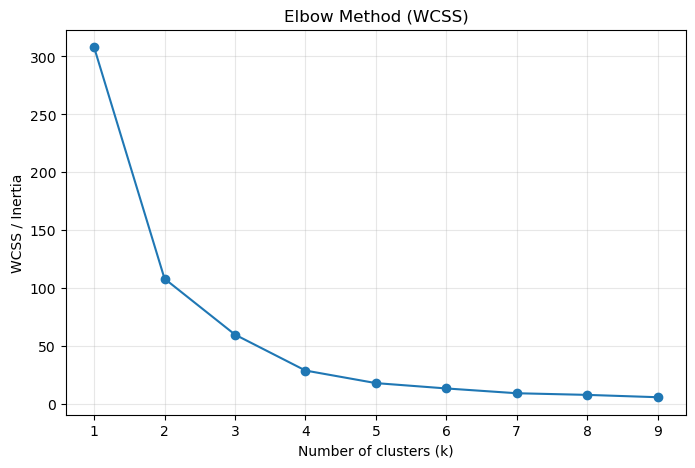

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1) Elbow curve: WCSS / Inertia
ks = range(1, 10)
wcss = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(Xz)  # standardized data from your code
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(ks, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS / Inertia')
plt.title('Elbow Method (WCSS)')
plt.xticks(ks)
plt.grid(True, alpha=0.3)
plt.show()


Plot the EXHIBIT 7

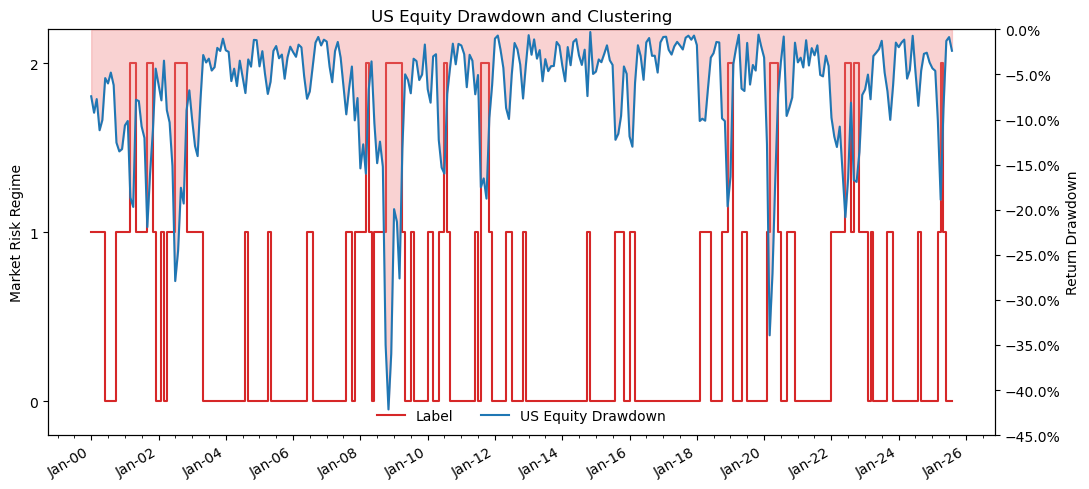

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# --- Align data (inner join on dates) ---
col = sp_3m_drawdown.columns[0]
df = (
    sp_3m_drawdown[[col]]
    .rename(columns={col: "drawdown"})
    .join(regimes[['regime']], how='inner')
    .dropna()
)

# --- Plot ---
fig, ax_left = plt.subplots(figsize=(11, 5))

# (1) Regime labels as a step plot on the LEFT y-axis (0/1/2)
ax_left.step(df.index, df['regime'], where='post', linewidth=1.5, color='tab:red', label='Label')
ax_left.set_ylim(-0.2, 2.2)
ax_left.set_yticks([0, 1, 2])
ax_left.set_yticklabels(['0', '1', '2'])
ax_left.set_ylabel('Market Risk Regime')

# change the index of the x-axis
ax_left.xaxis.set_major_locator(YearLocator(2))
ax_left.xaxis.set_minor_locator(MonthLocator(bymonth=(1,7))) 
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))

# (2) Drawdown on the RIGHT y-axis (percent), often inverted (0% at top)
ax_right = ax_left.twinx()
ax_right.plot(df.index, df['drawdown'], linewidth=1.5, color='tab:blue', label='US Equity Drawdown')
ax_right.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.fill_between(df.index, df['drawdown'], 0, where=(df['drawdown'] < 0), color='lightcoral', alpha=0.35)
ax_right.set_ylabel('Return Drawdown')
# Optional: set a range like 0% to -45% and invert so 0% is at the top
lo = np.nanmin(df['drawdown'])
ax_right.set_ylim(0.0, min(-0.45, lo*1.05))  # cap around -45%
ax_right.invert_yaxis()

# Titles and legend
ax_left.set_title('US Equity Drawdown and Clustering')
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))
fig.autofmt_xdate()

# Build a single legend (take one handle from each axis)
h1, l1 = ax_left.get_legend_handles_labels()
h2, l2 = ax_right.get_legend_handles_labels()
ax_left.legend(h1 + h2, l1 + l2, loc='lower center', ncols=2, frameon=False)

plt.tight_layout()
plt.show()

In [38]:
stage01_component02_target = regimes[['regime']].copy()

In [39]:
exploratory_data_analysis_pd_dataframe(stage01_component02_target)

The shape:
(308, 1)

The number of na data:
Ticker
regime    0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   regime  308 non-null    int64
dtypes: int64(1)
memory usage: 4.8 KB
None

The numberic profile of the input data:
Ticker      regime
count   308.000000
mean      0.467532
std       0.662331
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000

The skewness of the input dataframe:
Ticker
regime    1.101646
dtype: float64

The kurtosis of the input dataframe:
Ticker
regime    0.009612
dtype: float64


### Inputs for stage 01 stacking model

In [40]:
stage01_component02_inputs = pd.concat([financial_turbulence, financial_condition, equity_valuation, monetary_policy_expectation], axis = 1)

In [41]:
exploratory_data_analysis_pd_dataframe(stage01_component02_inputs)

The shape:
(308, 7)

The number of na data:
financial_turbulence    0
nfc_risk                0
nfc_credit              0
nfc_leverage            0
TR CAPE                 0
effr                    0
t3m effr spread         0
dtype: int64

The Info of the input dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2000-01-01 to 2025-08-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   financial_turbulence  308 non-null    float64
 1   nfc_risk              308 non-null    float64
 2   nfc_credit            308 non-null    float64
 3   nfc_leverage          308 non-null    float64
 4   TR CAPE               308 non-null    float64
 5   effr                  308 non-null    float64
 6   t3m effr spread       308 non-null    float64
dtypes: float64(7)
memory usage: 19.2 KB
None

The numberic profile of the input data:
       financial_turbulence    nfc_risk  nfc_credit  nfc_l

In [42]:
stage01_component02_data = pd.concat([stage01_component02_inputs, sp_3m_drawdown, stage01_component02_target], axis = 1)
stage01_component02_data = stage01_component02_data.rename(columns={'^GSPC':'sp_3m_drawdown'})

In [43]:
stage01_component02_data

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime
2000-01-01,22.841074,-0.258570,0.058478,1.317603,47.587687,5.45,0.049000,-0.074249,1
2000-02-01,40.765227,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1
2000-03-01,24.338714,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1
2000-04-01,17.526429,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1
2000-05-01,30.346908,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1
...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997304,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,2
2025-05-01,10.374257,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1
2025-06-01,7.777923,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,0
2025-07-01,7.594022,-0.538555,-0.048125,-0.525730,40.137466,4.33,0.082273,-0.008573,0


In [44]:
stage01_component02_data.to_csv("./data/raw/stage01_component02_based_on_sp500_data.csv", index = True)
stage01_component02_data.to_excel("./data/raw/stage01_component02_based_on_sp500_data.xlsx", index = True)

### Inputs for stage 02 

In [45]:
stage02_data = pd.concat([stage01_component02_data, real_gdp_growth, cpi_1y, cpi_10y], axis = 1)
stage02_data

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime,real_gdp_growth_monthly,cpi_1y,cpi_10y
2000-01-01,22.841074,-0.258570,0.058478,1.317603,47.587687,5.45,0.049000,-0.074249,1,50.167,0.021071,0.031022
2000-02-01,40.765227,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1,50.167,0.021640,0.030612
2000-03-01,24.338714,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1,50.167,0.024474,0.030337
2000-04-01,17.526429,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1,252.761,0.022689,0.030123
2000-05-01,30.346908,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1,252.761,0.023796,0.030044
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997304,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,2,222.766,0.027815,0.030659
2025-05-01,10.374257,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1,NaN,0.027671,0.030647
2025-06-01,7.777923,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,0,NaN,0.029079,0.030722
2025-07-01,7.594022,-0.538555,-0.048125,-0.525730,40.137466,4.33,0.082273,-0.008573,0,NaN,0.030486,0.030840


In [46]:
stage02_data.to_csv('./data/raw/stage02_data.csv', index = True)
stage02_data.to_excel('./data/raw/stage02_data.xlsx', index = True)
